## RTI Center for Data Science - Exercise 1
*Note: HAH! I somehow missed out on the relationships table in the SQLite database because it's not listed in the README. It's all fixed in part 2 though!*

Links to the full instructions and SQLite database can be found [here](https://github.com/rtidatascience/data-scientist-exercise01).

Briefly, the goal is to take some census data and use it to predict the probability that a person makes more or less than $50,000/year.

First, I'll import some of our go-to libraries, as well as *sqlite3*, which I'll use to connect to our SQLite database. I'll import other libraries later as we need them.

In [1]:
# do I want to run the full script or just select pieces of it?
runFull = False

import sqlite3
import pandas as pd
import numpy as np

conn = sqlite3.connect('./exercise01.sqlite')

### Getting data from the database
The goal here is to "flatten" the database into a single table using various IDs to pull relevant textual information from various supporting tables. There are many ways to do this, but I'm going to leverage pandas' *read_sql_query* function, which helpfully takes a SQL query and outputs it into Python as a DataFrame. I'm going to retain everything in our _records_ table (_SELECT r.*_), and just take the textual information from all of our other tables.

In [2]:
records = pd.read_sql_query("""SELECT r.*, w.name AS workclass, e.name AS education_level, 
                        m.name AS marital_status, o.name AS occupation, ra.name AS race,
                        s.name AS sex, c.name AS country                   
    FROM records AS r
    INNER JOIN workclasses AS w ON r.workclass_id=w.id
    INNER JOIN education_levels AS e ON r.education_level_id=e.id
    INNER JOIN marital_statuses AS m ON r.marital_status_id=m.id
    INNER JOIN occupations AS o ON r.occupation_id=o.id
    INNER JOIN races AS ra ON r.race_id=ra.id
    INNER JOIN sexes AS s ON r.sex_id=s.id
    INNER JOIN countries AS c ON r.country_id=c.id
    """, conn)

conn.close()
records.head()

,id,age,workclass_id,education_level_id,education_num,marital_status_id,occupation_id,relationship_id,race_id,sex_id,...,hours_week,country_id,over_50k,workclass,education_level,marital_status,occupation,race,sex,country
0,1,39,8,10,13,5,2,2,5,2,...,40,40,0,State-gov,Bachelors,Never-married,Adm-clerical,White,Male,United-States
1,2,50,7,10,13,3,5,1,5,2,...,13,40,0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,United-States
2,3,38,5,12,9,1,7,2,5,2,...,40,40,0,Private,HS-grad,Divorced,Handlers-cleaners,White,Male,United-States
3,4,53,5,2,7,3,7,1,3,2,...,40,40,0,Private,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,United-States
4,5,28,5,10,13,3,11,6,3,1,...,40,6,0,Private,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,Cuba


In [3]:
records.describe(include='all')

,id,age,workclass_id,education_level_id,education_num,marital_status_id,occupation_id,relationship_id,race_id,sex_id,...,hours_week,country_id,over_50k,workclass,education_level,marital_status,occupation,race,sex,country
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,...,48842.000000,48842.000000,48842.000000,48842,48842,48842,48842,48842,48842,48842
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9,16,7,15,5,2,42
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Private,HS-grad,Married-civ-spouse,Prof-specialty,White,Male,United-States
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,33906,15784,22379,6172,41762,32650,43832
mean,24421.500000,38.643585,4.870439,11.288420,10.078089,3.618750,7.577700,2.443287,4.668052,1.668482,...,40.422382,37.749355,0.239282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,14099.615261,13.710510,1.464234,3.874492,2.570973,1.507703,4.230509,1.602151,0.845986,0.470764,...,12.391444,7.775343,0.426649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,12211.250000,28.000000,5.000000,10.000000,9.000000,3.000000,4.000000,1.000000,5.000000,1.000000,...,40.000000,40.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,24421.500000,37.000000,5.000000,12.000000,10.000000,3.000000,8.000000,2.000000,5.000000,2.000000,...,40.000000,40.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,36631.750000,48.000000,5.000000,13.000000,12.000000,5.000000,11.000000,4.000000,5.000000,2.000000,...,45.000000,40.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Explore the data!
Step 1: explore the data! First, I'll look at the correlation structure (which will ignore the text inputs). I'll pay special attention to which variables are correlated with the target variables, *over_50k*.

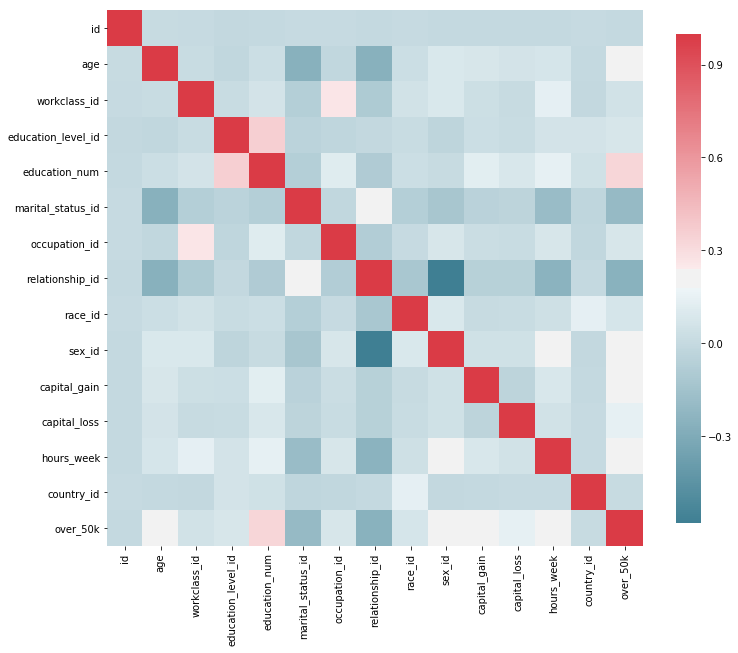

In [4]:
# look at correlation structure
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

corr = records.corr()
_ , ax = plt.subplots( figsize =( 12 , 10 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(
    corr, 
    vmin = -0.7, vmax = 0.7,
    cmap = cmap,
    square=True, 
    cbar_kws={ 'shrink' : .9 }, 
    ax=ax
)

In [5]:
# what are the dtypes of each variable?
records.dtypes

id                     int64
age                    int64
workclass_id           int64
education_level_id     int64
education_num          int64
marital_status_id      int64
occupation_id          int64
relationship_id        int64
race_id                int64
sex_id                 int64
capital_gain           int64
capital_loss           int64
hours_week             int64
country_id             int64
over_50k               int64
workclass             object
education_level       object
marital_status        object
occupation            object
race                  object
sex                   object
country               object
dtype: object

### Prepare data for model fitting
When I want to eventually fit a model to the dataset, I'll need to use dummy coding to represent the categorical variables. Here, I'm putting all of the numerical data into one DataFrame, putting all of my object (i.e., categorical) data into a second DataFrame, and verifying that there are no other types of data that I'm missing.

In [6]:
records_num = records.select_dtypes(include=['float64', 'int64'])
records_cat = records.select_dtypes(include=['object'])
records_other = records.select_dtypes(exclude=['object', 'float64', 'int64'])
records_other.shape

(48842, 0)

I can use the _groupby_ function to look at how the target variable changes across the categorical variables. I can potentially use this later to consolidate some of these categories. I'll occasionally find _?_ entries: these come from the SQL database and represent unknown data. I may want to go back and replace these with the category modes later on.

In [7]:
# for example, let's look at how workclass affects earnings
records.groupby(['workclass']).mean()['over_50k']

workclass
?                   0.094677
Federal-gov         0.391760
Local-gov           0.295599
Never-worked        0.000000
Private             0.217867
Self-emp-inc        0.553392
Self-emp-not-inc    0.278871
State-gov           0.267542
Without-pay         0.095238
Name: over_50k, dtype: float64

In [8]:
# iterate through our categorical variables and dummy code them
dummy = pd.DataFrame()
for i, var_name in enumerate(records_cat):
    newvar = pd.get_dummies(records_cat[var_name], prefix=var_name)
    dummy = pd.concat([dummy,newvar], axis=1)

In [9]:
# combine our numerical and dummy-coded data. look how many more features we have now!
data = pd.concat([records_num, dummy], axis=1)
data.shape

(48842, 111)

Now that I've dummy-coded our categorical data, I can split the whole dataset into a training set and testing set. If I do any sort of feature engineering or any other manipulations to our data, I'll need to either re-split my data or insert those cells above here and run the whole notebook again.

In [10]:
from sklearn.model_selection import train_test_split

test = data['over_50k']
train = data.drop(['over_50k'], axis=1)

train_X, test_X, train_y, test_y = train_test_split(train, test, train_size=0.7)

# for reproducible results, pick a random_state
# train_X, test_X, train_y, test_y = train_test_split(train, test, train_size=0.7, random_state=4)

/Users/zacharyabzug/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
train_y.shape

(34189,)

### Run a model!
I'm going to start with the simplest way to predict binary data: logistic regression. This will represent the benchmark to which I'll compare all further testing. If I implement any feature engineering, bagging, boosting, leastic nets, whatever!, I want to have a higher prediction accuracy on the held-out test set.

In [12]:
from sklearn.linear_model import LogisticRegression
mdl = LogisticRegression()
mdl.fit(train_X, train_y)
train_acc = mdl.score(train_X, train_y)
test_acc = mdl.score(test_X, test_y)

print(train_acc, test_acc)


0.8348884144022931 0.8326622534634546


The scores here are the classification accuracies for each observation. Our testing accuracy is 84%, which ain't half bad, especially for our simplest model! Somewhat surprisingly, our testing accuracy is even slightly higher than our training accuracy. Keep in mind, though, since our training and testing splits will be different every time the notebook is run, these numbers will change slightly. We can use the *random_state* input to *train_test_split* to get reproducible results: with *random_state = 4*, I got a training accuracy of 83.939% and a testing accuracy of 84.065%.

I'm going to dive down into these model fits a little bit. In particular, I'm going to look at how the model's coefficients are related to each predictor's correlation with *over_50k*.

In [13]:
corr2 = data.corr()
corrslice = corr2['over_50k'].drop(['over_50k'])

coefs = np.concatenate(mdl.coef_)

Text(0,0.5,'Regression Coefficient')

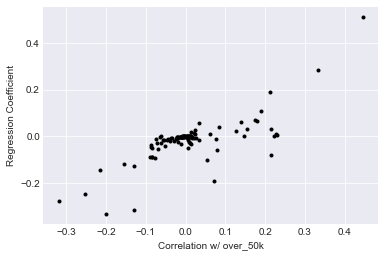

In [14]:
sns.set_style('darkgrid')
plt.plot(corrslice, coefs, 'k.')
plt.xlabel('Correlation w/ over_50k')
plt.ylabel('Regression Coefficient')

### Refine the model!
Now that I have an initial model, how can I refine it further? Based on the virtually identical training and testing accuracies, it seems like I can make the model more complex (i.e., we aren't overfitting to our training set). Since sklearn makes it so easy to train and run different models, I'm going to try a few more out before we worry about feature engineering. I'll start with other simple models and then progress to some ensemble models.

#### "Simple" models to start with:
- Logistic Regression - 84.06%
- **Support Vector Classifier**
- K-Nearest Neighbors
- Decision Tree
- Naive Bayes

In [15]:
## support vector classifier - takes a very long time, I don't recommend running this
#from sklearn.svm import SVC
#mdl = SVC(kernel='linear')
#mdl.fit(train_X, train_y)
#train_acc = mdl.score(train_X, train_y)
#test_acc = mdl.score(test_X, test_y)

#print(train_acc, test_acc)

SVC is currently being too slow to run this dataset with ~100 predictors and tens of thousands of observations. Maybe I'll try it again later when I have a better internet connection or I can't just let my computer run for a while. Onto K-Nearest Neighbors!

#### "Simple" models to start with:
- Logistic Regression - 84.06%
- Support Vector Classifier - DNF
- **K-Nearest Neighbors**
- Decision Tree
- Naive Bayes

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
    
if runFull:
    # how many neighbors to pick? let's use cross validation to figure it out!
    # using some help from https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

    # creating odd list of K for KNN
    myList = list(range(1,50))

    # subsetting just the odd ones
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 5-fold cross validation - skip this for now
    #for k in neighbors:
    #    mdl = KNeighborsClassifier(n_neighbors=k)
    #    scores = cross_val_score(mdl, train_X, train_y, cv=5, scoring='accuracy')
    #    cv_scores.append(scores.mean())

In [17]:
if runFull:
    # find the number of neighbors that led to best performance
    #best_k = neighbors[cv_scores.index(max(cv_scores))]
    best_k = 29
    print("The best number of neighbors is", best_k)


In [18]:
if runFull:
    # now I'll evaluate the test set using the best_k nearest neighbors
    mdl = KNeighborsClassifier(n_neighbors=best_k)
    mdl.fit(train_X, train_y)
    train_acc = mdl.score(train_X, train_y)
    test_acc = mdl.score(test_X, test_y)

    print(train_acc, test_acc)

K-Nearest Neighbors doesn't seem to be working as well as logistic regression did (the cross-validation takes a while too). This shouldn't be all that surprising because so many of our features are binary variables. Those binary predictors don't carry very much information in a KNN because there are only two possible values. On to the next one: decision trees!

#### "Simple" models to start with:
- Logistic Regression - 84.06%
- Support Vector Classifier - DNF
- K-Nearest Neighbors (k=29) - 80.4%
- **Decision Tree**
- Naive Bayes

In [19]:
# we'll again use cross-validation here to determine a parameter: max_depth, which controls tree size (and complexity)
from sklearn.tree import DecisionTreeClassifier

cv_scores = []
depth = list(range(3,20))

for k in depth:
    mdl = DecisionTreeClassifier(max_depth=k)
    scores = cross_val_score(mdl, train_X, train_y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    
best_depth = depth[cv_scores.index(max(cv_scores))]
print("The best tree depth is", best_depth)

The best tree depth is 8


In [20]:
# now I'll evaluate the test set using the best tree depth
mdl = DecisionTreeClassifier(max_depth=best_depth)
mdl.fit(train_X, train_y)
train_acc = mdl.score(train_X, train_y)
test_acc = mdl.score(test_X, test_y)

print(train_acc, test_acc)

0.8658340401883646 0.856070429263632


Even better than logistic regression! (By a small margin, at least.) The difference between the training and testing errors is still pretty small, so an ensemble approach might be even better. If a decision tree seems like it will be the best solution, though, we can use *GridSearchCV* to test the parameter space more expansively. Last but not least in our "simple" model category: Naive Bayes.

#### "Simple" models to start with:
- Logistic Regression - 84.06%
- Support Vector Classifier - DNF
- K-Nearest Neighbors (k=29) - 80.4%
- Decision Tree - 86.0%
- **Naive Bayes**

In [21]:
if runFull:
    # try Gaussian Naive Bayes, although it may not work well because of all of our binary predictors
    from sklearn.naive_bayes import GaussianNB

    mdl = GaussianNB()
    mdl.fit(train_X, train_y)

    train_acc = mdl.score(train_X, train_y)
    test_acc = mdl.score(test_X, test_y)

    print(train_acc, test_acc)

NB did alright, not great, as we expected.

#### "Simple" models to start with:
- Logistic Regression - 84.06%
- Support Vector Classifier - DNF
- K-Nearest Neighbors (k=29) - 80.4%
- Decision Tree - 86.0%
- Naive Bayes - 82.7%

Now I'll try out a few ensemble methods. Many of these utilize combinations of decision trees in order to increase accuracy, but they are also more prone to overfitting. I'll start out with the classic AdaBoost.

#### Ensemble models to start with:
- **AdaBoost**
- Random Forest
- Gradient Tree Boosting

In [22]:
# I'll start with 100 estimators
from sklearn.ensemble import AdaBoostClassifier

if runFull:
    mdl = AdaBoostClassifier(n_estimators=100)
    mdl.fit(train_X, train_y)
    train_acc = mdl.score(train_X, train_y)
    test_acc = mdl.score(test_X, test_y)

    print(train_acc, test_acc)

In [23]:
if runFull:
    # prediction is pretty good! let's see how it changes as a function of iteration number
    scores = list(mdl.staged_score(test_X, test_y))
    plt.plot(range(1,101),scores)
    plt.xlabel('n_estimators')
    plt.ylabel('test_acc')

In [24]:
# what about with a ton of estimators?
mdl = AdaBoostClassifier(n_estimators=1000)
mdl.fit(train_X, train_y)
train_acc = mdl.score(train_X, train_y)
test_acc = mdl.score(test_X, test_y)

print(train_acc, test_acc)

0.8746380414753283 0.8686958302054187


Text(0,0.5,'test_acc')

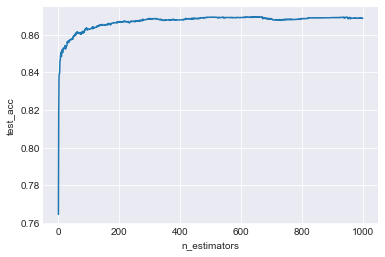

In [25]:
# we can do a little bit better, but prediction accuracy has all but saturated
scores = list(mdl.staged_score(test_X, test_y))
plt.plot(range(1,1001),scores)
plt.xlabel('n_estimators')
plt.ylabel('test_acc')

#### Ensemble models to start with:
- AdaBoost - 87.2%
- **Random Forest**
- Gradient Tree Boosting

In [26]:
from sklearn.ensemble import RandomForestClassifier

cv_scores = []
nEst = [100,200,250,300,350,400,450,500,550,600,700,800,1000]
for n in nEst:
    mdl = RandomForestClassifier(n_estimators=n)
    scores = cross_val_score(mdl, train_X, train_y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    
best_n = nEst[cv_scores.index(max(cv_scores))]
mdl = RandomForestClassifier(n_estimators=best_n)
mdl.fit(train_X, train_y)
train_acc = mdl.score(train_X, train_y)
test_acc = mdl.score(test_X, test_y)

print(best_n, train_acc, test_acc)

700 1.0 0.8497918514979867


Text(0,0.5,'test_acc')

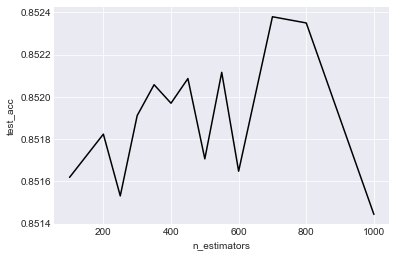

In [28]:
plt.plot(nEst,cv_scores,'k-')
plt.xlabel('n_estimators')
plt.ylabel('test_acc')

#### Ensemble models to start with:
- AdaBoost - 87.2%
- Random Forest - ??
- **Gradient Tree Boosting**

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

mdl = GradientBoostingClassifier(n_estimators=1000)
mdl.fit(train_X, train_y)
train_acc = mdl.score(train_X, train_y)
test_acc = mdl.score(test_X, test_y)

print(train_acc, test_acc)

0.8967796659744363 0.8696512659523647


Text(0,0.5,'test_acc')

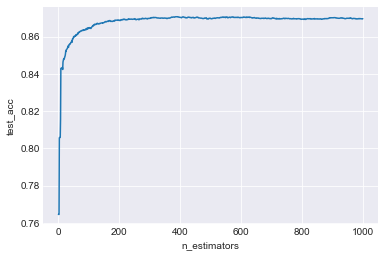

In [30]:
# again, check test_acc as a function of n_estimators
from sklearn.metrics import accuracy_score
scores = []
predictions = list(mdl.staged_predict(test_X))
for k in predictions:
    scores.append(accuracy_score(k,test_y))

plt.plot(range(1,1001),scores)
plt.xlabel('n_estimators')
plt.ylabel('test_acc')


In [31]:
print(max(scores), scores.index(max(scores)))

0.8706749471098069 385


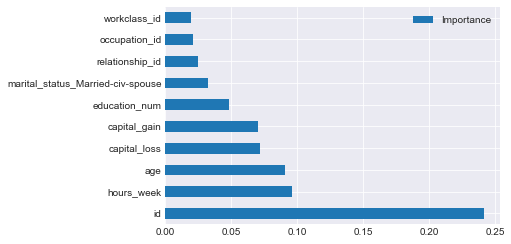

In [36]:
imp = pd.DataFrame( 
        mdl.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = train_X.columns 
    )
imp = imp.sort_values( [ 'Importance' ] , ascending = False )
imp[ : 10 ].plot( kind = 'barh' )